In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from os import listdir
import random, warnings

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2, tensorflow.keras, tensorflow.keras.utils
import sys, argparse, json, operator

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Input, GlobalAveragePooling3D
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.python.keras.layers.normalization import BatchNormalization

import efficientnet.tfkeras as efn ## efficientnet.keras or ...
from efficientnet.tfkeras import EfficientNetB0
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input

C:\Users\dell\anaconda3\envs\tf2.0-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dell\anaconda3\envs\tf2.0-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dell\anaconda3\envs\tf2.0-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dell\anaconda3\envs\tf2.0-gpu\lib\site-packages\tensorf

In [2]:
basePath = r'C:\Users\dell\new_kdy'

IMG_W, IMG_H = 224, 224
batch_size, iteration = 1351, 3

generator = ImageDataGenerator(rescale = 1./255)
obj0 = generator.flow_from_directory(basePath,
                                    target_size = (IMG_W,IMG_H),
                                    batch_size=batch_size,
                                    class_mode='categorical')
img0, label0 = obj0.next()

generator = ImageDataGenerator(
                        rotation_range = 20,
                        width_shift_range = 0.0,
                        height_shift_range = 0.0,
                        rescale = 1./255)
obj = generator.flow_from_directory(basePath,
                                    target_size = (IMG_W,IMG_H),
                                    batch_size=batch_size,
                                    class_mode='categorical')
for i in range(iteration):
    img, label = obj.next()
    img0 = np.append(img0, img, axis=0)
    label0 = np.append(label0, label, axis=0)

print('Rotation Clear')
print(img0.shape)
print(label0.shape)

generator = ImageDataGenerator(
                        rotation_range = 0,
                        width_shift_range = 0.2,
                        height_shift_range = 0.0,
                        rescale = 1./255)
obj2 = generator.flow_from_directory(basePath,
                                    target_size = (IMG_W,IMG_H),
                                    batch_size=batch_size,
                                    class_mode='categorical')
for i in range(iteration):
    img2, label2 = obj2.next()
    img0 = np.append(img0, img2, axis=0)
    label0 = np.append(label0, label2, axis=0)

print('Width Shift Clear')
print(img0.shape)
print(label0.shape)

generator = ImageDataGenerator(
                        rotation_range = 0,
                        width_shift_range = 0.0,
                        height_shift_range = 0.2,
                        rescale = 1./255)
obj3 = generator.flow_from_directory(basePath,
                                    target_size = (IMG_W,IMG_H),
                                    batch_size=batch_size,
                                    class_mode='categorical')
for i in range(iteration):
    img3, label3 = obj3.next()
    img0 = np.append(img0, img3, axis=0)
    label0 = np.append(label0, label3, axis=0)

print('Height Shift Clear')
print(img0.shape)
print(label0.shape)

Found 1351 images belonging to 16 classes.
Found 1351 images belonging to 16 classes.
Rotation Clear
(5404, 224, 224, 3)
(5404, 16)
Found 1351 images belonging to 16 classes.
Width Shift Clear
(9457, 224, 224, 3)
(9457, 16)
Found 1351 images belonging to 16 classes.
Height Shift Clear
(13510, 224, 224, 3)
(13510, 16)


In [3]:
train_images,test_images,train_labels,test_labels=train_test_split(img0,label0,test_size=0.2, random_state=99)

In [4]:
datagen = ImageDataGenerator(
        horizontal_flip=True,
        fill_mode='nearest')
datagen.fit(train_images)

In [5]:
bottom_model = EfficientNetB0(weights='imagenet')
bottom_model.trainable = False

x = bottom_model.output
#x = GlobalAveragePooling3D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
pred_x = Dense(16, activation='softmax')(x)
model = Model(inputs=bottom_model.input, outputs=pred_x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [6]:
model.compile(optimizer=Adam(lr=0.001),
             loss='categorical_crossentropy', metrics=['accuracy'])
red_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.1)
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
callbacks = [es,red_lr]

In [7]:
batch_size, epochs = 32, 100
History = model.fit_generator(
                            datagen.flow(train_images, train_labels, batch_size = batch_size),
                            steps_per_epoch = train_images.shape[0] // batch_size,
                            epochs = epochs,
                            callbacks = callbacks,
                            validation_data = (test_images, test_labels))

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
337/337 [==============================] - 41s 122ms/step - loss: 1.6453 - accuracy: 0.4642 - val_loss: 1.0580 - val_accuracy: 0.6536
Epoch 2/100
337/337 [==============================] - 34s 101ms/step - loss: 1.0297 - accuracy: 0.6624 - val_loss: 0.9063 - val_accuracy: 0.7010
Epoch 3/100
337/337 [==============================] - 34s 100ms/step - loss: 0.8522 - accuracy: 0.7172 - val_loss: 0.6582 - val_accuracy: 0.7879
Epoch 4/100
337/337 [==============================] - 34s 101ms/step - loss: 0.7416 - accuracy: 0.7534 - val_loss: 0.5246 - val_accuracy: 0.8272
Epoch 5/100
337/337 [==============================] - 35s 103ms/step - loss: 0.6384 - accuracy: 0.7880 - val_loss: 0.4617 - val_accuracy: 0.8416
Epoch 6/100
337/337 [==============================] - 34s 102ms/step - loss: 0.5750 - accuracy: 0.8094 - val_loss: 0.4230 - val_accuracy: 0.8601
Epoch 7/100
337/337 [=========

In [8]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04306402779709917
Test accuracy: 0.98704666


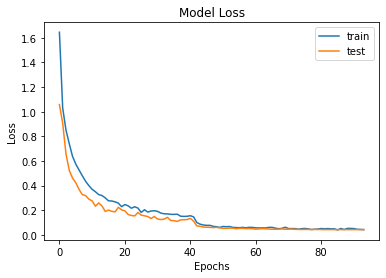

In [9]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

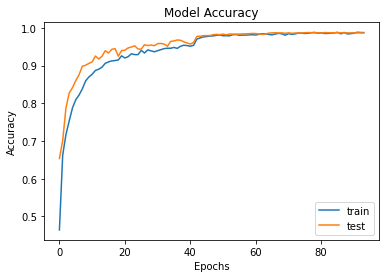

In [10]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [11]:
pred = model.predict(test_images)
pred_digits = np.argmax(pred, axis=1)
pred_Y = to_categorical(pred_digits, 16)
print(classification_report(test_labels, pred_Y))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       179
           1       1.00      0.97      0.99       158
           2       0.99      0.99      0.99       155
           3       0.96      0.98      0.97       173
           4       1.00      1.00      1.00       157
           5       0.99      0.98      0.98       195
           6       0.97      0.99      0.98       162
           7       0.99      1.00      1.00       153
           8       0.99      0.99      0.99       168
           9       1.00      0.98      0.99       176
          10       0.99      0.98      0.99       167
          11       0.99      0.99      0.99       179
          12       0.97      0.98      0.98       157
          13       0.98      0.99      0.99       182
          14       0.99      0.99      0.99       171
          15       0.98      0.99      0.99       170

   micro avg       0.99      0.99      0.99      2702
   macro avg       0.99   

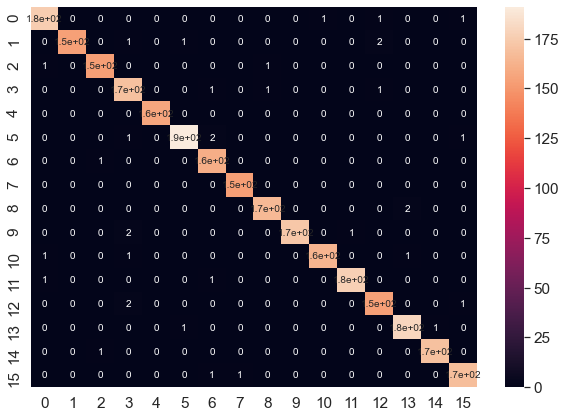

In [12]:
real_Y = np.argmax(test_labels, axis=1, out=None)
cnf_matrix = confusion_matrix(real_Y, pred_digits)
df_cm = pd.DataFrame(cnf_matrix, range(16), range(16))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size":10})
plt.show()